### Load libraries

#### Base Imports

In [1]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

#### ML imports

In [2]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

from sklearn.neural_network import MLPRegressor

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

### Load the datasets

- Dataset de testing --> Febrero - 2019

- Dataset de training --> Datos Anuales - 2018

In [4]:
train_data = pd.read_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\data\\ausol\\anual_data_18_mod.csv', delimiter=";")
test_data = pd.read_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\data\\ausol\\monthly\\02-19.csv', delimiter=";")

### Filter & Clean the datasets

In [5]:
# ----> train data

# Clean
train_data = train_data.drop_duplicates(['MES','FECHA', 'ID_SEGMENT'], keep='first').fillna(method='ffill') # fill with the last value
train_data = train_data.dropna(how='all')
train_data.rename(columns={'ID_SEGMENTO': 'ID_SEGMENT'}, inplace=True)

# Add temporal features
train_data['TIME'] =pd.to_datetime(train_data['FECHA']).map(lambda x: x.strftime('%d %H:%M:%S'))
train_data.sort_values(by=['MES','TIME'], inplace=True)
train_data = train_data.reset_index(drop=True)
train_data['DIA']=pd.to_datetime(train_data['FECHA']).dt.day
train_data = train_data.set_index(pd.DatetimeIndex(train_data['FECHA']))

# ----> test data 

# Clean
test_data = test_data.drop_duplicates(['MES','FECHA', 'ID_SEGMENT'], keep='first').fillna(method='ffill') # fill with the last value
test_data = test_data.dropna(how='all')

# Add temporal features
test_data['TIME'] =pd.to_datetime(test_data['FECHA']).map(lambda x: x.strftime('%d %H:%M:%S'))
test_data.sort_values(by=['TIME'], inplace=True)
test_data = test_data.reset_index(drop=True)
test_data['DIA']=pd.to_datetime(test_data['FECHA']).dt.day
test_data = test_data.set_index(pd.DatetimeIndex(test_data['FECHA']))



In [7]:
test_data.iloc[:,7:-1].loc[test_data['ID_SEGMENT']==1]['2019-02-01 00:00:00':'2019-02-02 00:00:00'].plot(linewidth=0.9,  figsize=(20, 8))


### Test specification

#### Build the training sets

In [452]:
cluster_features = ['ID_SEGMENT']#, 'COD_LABORALIDAD', 'MES']
excluded_features = ['TIME','FECHA']
excluded_features.extend(cluster_features)
forecast_horizon = [15, 60, 120] 

In [453]:
print(excluded_features)

['TIME', 'FECHA', 'ID_SEGMENT']


In [454]:
#'models ids are based on cluster_code + '_' + 'time_horizon'
mlmodels_dict = {'linear_regression':{'is_active': True, 'train_model': True, 'method':LinearRegression() }, 
                 'ada_boost':{'is_active': True, 'train_model': True, 'method':AdaBoostRegressor() }, 
                 'random_forest':{'is_active': True, 'train_model': True, 'method': RandomForestRegressor() }, 
                 'extra_trees_1':{'is_active': True, 'train_model': True, 'method': ExtraTreesRegressor() },  
                 'extra_trees_2':{'is_active': True, 'train_model': True, 'method': ExtraTreesRegressor(min_samples_leaf=10) }, 
                 'gradient_boosting':{'is_active': True, 'train_model': True, 'method': GradientBoostingRegressor() },  
                 'bagging_regressor':{'is_active': True, 'train_model': True, 'method': BaggingRegressor() }, 
                 'mlp_neural_network':{'is_active': True,'train_model': True, 'method': MLPRegressor()}, 
                 'kn_neighbors':{'is_active': True,'train_model': True,'method': KNeighborsRegressor(n_neighbors=2) }}

### Model training

In [455]:
# It splits train data in clusters 
# cluster features should be provided based on a descriptive analytics
# these features will be used for agent model specialization
# an expert model will be specilized on different feature values

    
    
'''
algorithm_name = 'RandomForest'
model_expertise = {
                    'target': 'TOTAL_VEHICULOS',
                    'excluded_features': ['TIME','FECHA','ID_SEGMENTO', 'COD_LABORALIDAD'],
                    'cluster_features' : ['ID_SEGMENT', 'MES', 'COD_LABORALIDAD'], 
                    'apply_rules': {
                                   'rule':{
                                       'on_feature':'ID_SEGMENT', 
                                       'exclude_values': [],
                                   } 
                                   
                             },
                   
                    
                    }
                    
forecast_strategy = {
                        'method' : 'direct', # https://machinelearningmastery.com/multi-step-time-series-forecasting/
                        'forecast_horizon' : [15, 60, 120],  # minutes
                    }


'''
import itertools
import copy 
clusters_codes = [element for element in itertools.product(*list(map(lambda x: train_data[x].unique().tolist(), cluster_features)))]


if len(cluster_features)==1:
    clusters_codes = [code[0] for code in clusters_codes ]
    
#print(clusters_codes) 

training_sets = dict.fromkeys(clusters_codes) # key: expert_code | value: train_set

# fill the training sets Python dict
for expert_code in training_sets:
    df_train = train_data  # restore pandas dataframe

    if len(cluster_features)==1:
        df_train = df_train.loc[df_train[str(cluster_features[0])]==expert_code]
    else:
        for key, value in zip(cluster_features, expert_code):
            df_train = copy.deepcopy(df_train.loc[df_train[key]==value])
    
    training_sets[expert_code] = copy.deepcopy(df_train)

#print(training_sets[clusters_codes[1]].shape)
    

In [456]:
clusters_codes[2]

3.0

In [457]:
training_sets[clusters_codes[2]]

,ID_SEGMENT,COD_LABORALIDAD,FECHA,MES,HORA,MINUTO,CANTIDAD_PREC,TOTAL_VEHICULOS,TOTAL_VEHICULOS_1,TOTAL_VEHICULOS_2,...,TOTAL_VEHICULOS_17,TOTAL_VEHICULOS_18,TOTAL_VEHICULOS_19,TOTAL_VEHICULOS_20,TOTAL_VEHICULOS_21,TOTAL_VEHICULOS_22,TOTAL_VEHICULOS_23,TOTAL_VEHICULOS_24,TIME,DIA
FECHA,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,3.0,2.0,2018-01-01 00:00:00,1.0,0.0,0.0,0.0,72.0,134.0,176.0,...,223.0,250.0,261.0,266.0,271.0,335.0,339.0,293.0,01 00:00:00,1
2018-01-01 00:15:00,3.0,2.0,2018-01-01 00:15:00,1.0,0.0,15.0,0.0,35.0,72.0,134.0,...,244.0,223.0,250.0,261.0,266.0,271.0,335.0,339.0,01 00:15:00,1
2018-01-01 00:30:00,3.0,2.0,2018-01-01 00:30:00,1.0,0.0,30.0,0.0,82.0,35.0,72.0,...,177.0,244.0,223.0,250.0,261.0,266.0,271.0,335.0,01 00:30:00,1
2018-01-01 00:45:00,3.0,2.0,2018-01-01 00:45:00,1.0,0.0,45.0,0.0,177.0,82.0,35.0,...,161.0,177.0,244.0,223.0,250.0,261.0,266.0,271.0,01 00:45:00,1
2018-01-01 01:00:00,3.0,2.0,2018-01-01 01:00:00,1.0,1.0,0.0,0.0,232.0,177.0,82.0,...,141.0,161.0,177.0,244.0,223.0,250.0,261.0,266.0,01 01:00:00,1
2018-01-01 01:15:00,3.0,2.0,2018-01-01 01:15:00,1.0,1.0,15.0,0.0,215.0,232.0,177.0,...,102.0,141.0,161.0,177.0,244.0,223.0,250.0,261.0,01 01:15:00,1
2018-01-01 01:30:00,3.0,2.0,2018-01-01 01:30:00,1.0,1.0,30.0,0.0,209.0,215.0,232.0,...,95.0,102.0,141.0,161.0,177.0,244.0,223.0,250.0,01 01:30:00,1
2018-01-01 01:45:00,3.0,2.0,2018-01-01 01:45:00,1.0,1.0,45.0,0.0,214.0,209.0,215.0,...,59.0,95.0,102.0,141.0,161.0,177.0,244.0,223.0,01 01:45:00,1
2018-01-01 02:00:00,3.0,2.0,2018-01-01 02:00:00,1.0,2.0,0.0,0.0,196.0,214.0,209.0,...,85.0,59.0,95.0,102.0,141.0,161.0,177.0,244.0,01 02:00:00,1


In [458]:
import pickle
store_model = True
import copy

def regression(regressor, regr_name, x_train, y_train):
    reg = copy.deepcopy(regressor.fit(x_train, y_train))
    param_grid = {}#'n_estimators': [500], 'max_features': [10,15,20]}
    #reg = GridSearchCV(estimator=reg, param_grid=param_grid, n_jobs=1, cv=10, scoring='neg_mean_squared_error')
    print('Precision del modelo:')
    precision = reg.score(x_train, y_train)
    print(precision)
    
    if store_model:
        save_dir = os.path.join(os.getcwd(), regr_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        model_id = regr_name + '_' + str(cluster_code) + '_' + str(horizon)
        print("Model " + str(model_id) + " succesfully generated! Saving it...") 
        model_path = os.path.join(regr_name, model_id + ".sav")
        pickle.dump(reg, open(model_path, 'wb'))
    
    return reg

In [ ]:
import os
import copy


for regr_name, regr_properties in mlmodels_dict.items():
    if regr_properties['train_model']==True and regr_properties['is_active']==True:
        for cluster_code, trainset in training_sets.items(): # access the training sets
            for horizon in forecast_horizon:
                step = int(horizon/15)

                x_train = trainset.loc[:, trainset.columns.difference(excluded_features)][:-step] 
                y_train = trainset['TOTAL_VEHICULOS'][step:]
                
                mlmodels_dict[regr_name][str(cluster_code) + '_' + str(horizon)] = regression(regr_properties['method'], regr_name, x_train, y_train)
    

Precision del modelo:
0.9194649453245873
Model linear_regression_1_15 succesfully generated! Saving it...
Precision del modelo:
0.837700129070815
Model linear_regression_1_60 succesfully generated! Saving it...
Precision del modelo:
0.7182023628053515
Model linear_regression_1_120 succesfully generated! Saving it...
Precision del modelo:
0.8942864563301446
Model linear_regression_2_15 succesfully generated! Saving it...
Precision del modelo:
0.7683372655576228
Model linear_regression_2_60 succesfully generated! Saving it...
Precision del modelo:
0.6286688707496167
Model linear_regression_2_120 succesfully generated! Saving it...
Precision del modelo:
0.9214979898742744
Model linear_regression_3_15 succesfully generated! Saving it...
Precision del modelo:
0.8397484158622748
Model linear_regression_3_60 succesfully generated! Saving it...
Precision del modelo:
0.7181536280797448
Model linear_regression_3_120 succesfully generated! Saving it...
Precision del modelo:
0.9079180958246043
Mod

Precision del modelo:
0.8091495576123406
Model linear_regression_35_60 succesfully generated! Saving it...
Precision del modelo:
0.6432007006225489
Model linear_regression_35_120 succesfully generated! Saving it...
Precision del modelo:
0.8595187792547239
Model linear_regression_39_15 succesfully generated! Saving it...
Precision del modelo:
0.7466607885414749
Model linear_regression_39_60 succesfully generated! Saving it...
Precision del modelo:
0.5963578009051302
Model linear_regression_39_120 succesfully generated! Saving it...
Precision del modelo:
0.8069807278898943
Model linear_regression_40_15 succesfully generated! Saving it...
Precision del modelo:
0.7129407374763028
Model linear_regression_40_60 succesfully generated! Saving it...
Precision del modelo:
0.5887139065353715
Model linear_regression_40_120 succesfully generated! Saving it...
Precision del modelo:
0.8049651482181007
Model linear_regression_42_15 succesfully generated! Saving it...
Precision del modelo:
0.7025432103

Precision del modelo:
0.8808597455444814
Model ada_boost_16_15 succesfully generated! Saving it...
Precision del modelo:
0.722130469772496
Model ada_boost_16_60 succesfully generated! Saving it...
Precision del modelo:
0.66176251487464
Model ada_boost_16_120 succesfully generated! Saving it...
Precision del modelo:
0.7642417941473255
Model ada_boost_17_15 succesfully generated! Saving it...
Precision del modelo:
0.6606963372215324
Model ada_boost_17_60 succesfully generated! Saving it...
Precision del modelo:
0.5098121479626576
Model ada_boost_17_120 succesfully generated! Saving it...
Precision del modelo:
0.7051733643675432
Model ada_boost_18_15 succesfully generated! Saving it...
Precision del modelo:
0.5974955975274472
Model ada_boost_18_60 succesfully generated! Saving it...
Precision del modelo:
0.2956958844325617
Model ada_boost_18_120 succesfully generated! Saving it...
Precision del modelo:
0.10627394479694419
Model ada_boost_19_15 succesfully generated! Saving it...
Precision

Precision del modelo:
0.9816289622398313
Model random_forest_3_120 succesfully generated! Saving it...
Precision del modelo:
0.9834201947316477
Model random_forest_4_15 succesfully generated! Saving it...
Precision del modelo:
0.9795312377126163
Model random_forest_4_60 succesfully generated! Saving it...
Precision del modelo:
0.9781289753410451
Model random_forest_4_120 succesfully generated! Saving it...
Precision del modelo:
0.9834057350765074
Model random_forest_6_15 succesfully generated! Saving it...
Precision del modelo:
0.9793934788956412
Model random_forest_6_60 succesfully generated! Saving it...
Precision del modelo:
0.9779725868786082
Model random_forest_6_120 succesfully generated! Saving it...
Precision del modelo:
0.9897733406172481
Model random_forest_7_15 succesfully generated! Saving it...
Precision del modelo:
0.9851858108323793
Model random_forest_7_60 succesfully generated! Saving it...
Precision del modelo:
0.9826568336544238
Model random_forest_7_120 succesfully 

Precision del modelo:
0.9672071012400306
Model random_forest_42_60 succesfully generated! Saving it...
Precision del modelo:
0.9634707513124374
Model random_forest_42_120 succesfully generated! Saving it...
Precision del modelo:
0.9438658885979795
Model random_forest_43_15 succesfully generated! Saving it...
Precision del modelo:
0.9480778056958397
Model random_forest_43_60 succesfully generated! Saving it...
Precision del modelo:
0.9499937019103492
Model random_forest_43_120 succesfully generated! Saving it...
Precision del modelo:
0.9850376214440413
Model random_forest_100_15 succesfully generated! Saving it...
Precision del modelo:
0.9822844514466396
Model random_forest_100_60 succesfully generated! Saving it...
Precision del modelo:
0.9819485058897728
Model random_forest_100_120 succesfully generated! Saving it...
Precision del modelo:
0.9921277384506975
Model random_forest_101_15 succesfully generated! Saving it...
Precision del modelo:
0.9896145621258156
Model random_forest_101_6

Precision del modelo:
1.0
Model extra_trees_1_21_15 succesfully generated! Saving it...
Precision del modelo:
0.9999997540542317
Model extra_trees_1_21_60 succesfully generated! Saving it...
Precision del modelo:
1.0
Model extra_trees_1_21_120 succesfully generated! Saving it...
Precision del modelo:
0.9999999976251706
Model extra_trees_1_22_15 succesfully generated! Saving it...
Precision del modelo:
1.0
Model extra_trees_1_22_60 succesfully generated! Saving it...
Precision del modelo:
1.0
Model extra_trees_1_22_120 succesfully generated! Saving it...
Precision del modelo:
0.9999999993733272
Model extra_trees_1_30_15 succesfully generated! Saving it...
Precision del modelo:
0.9999999974931358
Model extra_trees_1_30_60 succesfully generated! Saving it...
Precision del modelo:
1.0
Model extra_trees_1_30_120 succesfully generated! Saving it...
Precision del modelo:
1.0
Model extra_trees_1_31_15 succesfully generated! Saving it...
Precision del modelo:
0.9999999710936143
Model extra_tree

C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision del modelo:
0.9540446075934793
Model extra_trees_2_1_15 succesfully generated! Saving it...
Precision del modelo:
0.9394498398179201
Model extra_trees_2_1_60 succesfully generated! Saving it...
Precision del modelo:
0.933739787118241
Model extra_trees_2_1_120 succesfully generated! Saving it...
Precision del modelo:
0.93697499029415
Model extra_trees_2_2_15 succesfully generated! Saving it...
Precision del modelo:
0.8993543029710381
Model extra_trees_2_2_60 succesfully generated! Saving it...
Precision del modelo:
0.8847668316012909
Model extra_trees_2_2_120 succesfully generated! Saving it...
Precision del modelo:
0.9550374525732896
Model extra_trees_2_3_15 succesfully generated! Saving it...
Precision del modelo:
0.9412348846547035
Model extra_trees_2_3_60 succesfully generated! Saving it...
Precision del modelo:
0.9346098687624047
Model extra_trees_2_3_120 succesfully generated! Saving it...
Precision del modelo:
0.944710422465253
Model extra_trees_2_4_15 succesfully gener

Precision del modelo:
0.9582254948629098
Model extra_trees_2_35_120 succesfully generated! Saving it...
Precision del modelo:
0.9401875226404524
Model extra_trees_2_39_15 succesfully generated! Saving it...
Precision del modelo:
0.9328302916172244
Model extra_trees_2_39_60 succesfully generated! Saving it...
Precision del modelo:
0.9303478298641346
Model extra_trees_2_39_120 succesfully generated! Saving it...
Precision del modelo:
0.8924987890884686
Model extra_trees_2_40_15 succesfully generated! Saving it...
Precision del modelo:
0.888801873037333
Model extra_trees_2_40_60 succesfully generated! Saving it...
Precision del modelo:
0.8851540065403184
Model extra_trees_2_40_120 succesfully generated! Saving it...
Precision del modelo:
0.8937181910195415
Model extra_trees_2_42_15 succesfully generated! Saving it...
Precision del modelo:
0.8823940764325277
Model extra_trees_2_42_60 succesfully generated! Saving it...
Precision del modelo:
0.8783638235464027
Model extra_trees_2_42_120 suc

Precision del modelo:
0.888227646150332
Model gradient_boosting_15_120 succesfully generated! Saving it...
Precision del modelo:
0.9470224877747544
Model gradient_boosting_16_15 succesfully generated! Saving it...
Precision del modelo:
0.9151354672009571
Model gradient_boosting_16_60 succesfully generated! Saving it...
Precision del modelo:
0.8861582030828334
Model gradient_boosting_16_120 succesfully generated! Saving it...
Precision del modelo:
0.930219928314682
Model gradient_boosting_17_15 succesfully generated! Saving it...
Precision del modelo:
0.8966722543688742
Model gradient_boosting_17_60 succesfully generated! Saving it...
Precision del modelo:
0.8669669777431934
Model gradient_boosting_17_120 succesfully generated! Saving it...
Precision del modelo:
0.9168234988312545
Model gradient_boosting_18_15 succesfully generated! Saving it...
Precision del modelo:
0.8671143558764641
Model gradient_boosting_18_60 succesfully generated! Saving it...
Precision del modelo:
0.828524669894

Precision del modelo:
0.9832559955058846
Model bagging_regressor_1_60 succesfully generated! Saving it...
Precision del modelo:
0.9811797541653566
Model bagging_regressor_1_120 succesfully generated! Saving it...
Precision del modelo:
0.981649260236373
Model bagging_regressor_2_15 succesfully generated! Saving it...
Precision del modelo:
0.9716375807855786
Model bagging_regressor_2_60 succesfully generated! Saving it...
Precision del modelo:
0.9662329495544563
Model bagging_regressor_2_120 succesfully generated! Saving it...
Precision del modelo:
0.9868038888692268
Model bagging_regressor_3_15 succesfully generated! Saving it...
Precision del modelo:
0.983586271308114
Model bagging_regressor_3_60 succesfully generated! Saving it...
Precision del modelo:
0.9808769545515786
Model bagging_regressor_3_120 succesfully generated! Saving it...
Precision del modelo:
0.9835049545963048
Model bagging_regressor_4_15 succesfully generated! Saving it...
Precision del modelo:
0.9802911069202157
Mode

Precision del modelo:
0.9924501666671878
Model bagging_regressor_35_15 succesfully generated! Saving it...
Precision del modelo:
0.9896535415317309
Model bagging_regressor_35_60 succesfully generated! Saving it...
Precision del modelo:
0.9888557242719941
Model bagging_regressor_35_120 succesfully generated! Saving it...
Precision del modelo:
0.9846435662381646
Model bagging_regressor_39_15 succesfully generated! Saving it...
Precision del modelo:
0.9812261587687074
Model bagging_regressor_39_60 succesfully generated! Saving it...
Precision del modelo:
0.9812073485366085
Model bagging_regressor_39_120 succesfully generated! Saving it...
Precision del modelo:
0.9586189141115792
Model bagging_regressor_40_15 succesfully generated! Saving it...
Precision del modelo:
0.9763070128296111
Model bagging_regressor_40_60 succesfully generated! Saving it...
Precision del modelo:
0.9721194404435575
Model bagging_regressor_40_120 succesfully generated! Saving it...
Precision del modelo:
0.9731851754

C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.9152698221033051
Model mlp_neural_network_2_15 succesfully generated! Saving it...
Precision del modelo:
0.8324751461827606
Model mlp_neural_network_2_60 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.7757641847563848
Model mlp_neural_network_2_120 succesfully generated! Saving it...
Precision del modelo:
0.9345423745227256
Model mlp_neural_network_3_15 succesfully generated! Saving it...
Precision del modelo:
0.8903774102188127
Model mlp_neural_network_3_60 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.848259653883918
Model mlp_neural_network_3_120 succesfully generated! Saving it...
Precision del modelo:
0.9180378507927106
Model mlp_neural_network_4_15 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.8728692694117322
Model mlp_neural_network_4_60 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.8220306730955168
Model mlp_neural_network_4_120 succesfully generated! Saving it...
Precision del modelo:
0.9250513775269523
Model mlp_neural_network_6_15 succesfully generated! Saving it...
Precision del modelo:
0.8667604806834577
Model mlp_neural_network_6_60 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.8199140530251152
Model mlp_neural_network_6_120 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.9494544330355957
Model mlp_neural_network_7_15 succesfully generated! Saving it...


C:\Users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Precision del modelo:
0.8970282904500484
Model mlp_neural_network_7_60 succesfully generated! Saving it...


## Sanity test

In [103]:
mlmodels_dict['extra_trees_2']

{'is_active': True,
 'train_model': True,
 'method': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 1.0)_15': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 1.0)_60': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 1.0)_120': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 2.0)_15': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 2.0)_60': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 2.0)_120': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 3.0)_15': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 '(1.0, 2.0, 3.0)_60': LinearRegression(copy_X=True, fit

In [40]:
import pickle
store_results=True

if store_results: 
    save_path = os.path.join(os.getcwd(), 'direct_mlmodels_dict_' + str(cluster_features) + str(forecast_horizon) +'.sav')
    pickle.dump(mlmodels_dict, open(save_path, 'wb'))

### Model restoring

In [14]:
import os
import pickle

for regr_name, regr_properties in mlmodels_dict.items():
    if regr_properties['is_active']==True:
        for cluster_code, trainset in training_sets.items():
            for horizon in forecast_horizon:
                model_file = regr_name + '_' + str(cluster_code) + '_' + str(horizon) + ".sav" 
                model_path = os.path.join(os.getcwd(),regr_name, model_file)
                model_file  = pickle.load( open(model_path, "rb" ) ) 
                
                mlmodels_dict[regr_name][str(cluster_code) + '_' + str(horizon)] = model_file


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\notebooks\\model_generation\\linear_regression\\linear_regression_1.0_15.sav'

### Model Evaluation

In [ ]:
store_results =  True

In [24]:
score_metrics = {
                        'score_metrics' : {
                            'ev': {'train':0, 'test':0},
                            'r2': {'train':0, 'test':0}, 
                            'mse': {'train':0, 'test':0},
                            'mdae': {'train':0, 'test':0},
                            'mae': {'train':0, 'test':0}, 
                        },
                        'y_pred': {'train':0, 'test':0},
                }
                    

In [34]:
def scores(model_id, regressor, model_name, x_train, x_test, y_train, y_test):
    evaluation_toolset=dict()
    y_train_reg=0
    y_test_reg=0
   
    evaluation_toolset[str(model_name)] = score_metrics
    y_train_reg = model.predict(x_train)
    evaluation_toolset[str(model_name)]['y_pred']['train'] = y_train_reg
    y_test_reg = model.predict(x_test)
    evaluation_toolset[str(model_name)]['y_pred']['test'] = y_test_reg
    
    evaluation_toolset[str(model_name)]['score_metrics']['ev']['train'] = explained_variance_score(y_train, y_train_reg)
    evaluation_toolset[str(model_name)]['score_metrics']['ev']['test'] = explained_variance_score(y_test, y_test_reg)
 
    evaluation_toolset[str(model_name)]['score_metrics']['r2']['train'] = r2_score(y_train, y_train_reg)
    evaluation_toolset[str(model_name)]['score_metrics']['r2']['test'] = r2_score(y_test, y_test_reg)
    
    evaluation_toolset[str(model_name)]['score_metrics']['mse']['train'] = mean_squared_error(y_train, y_train_reg)
    evaluation_toolset[str(model_name)]['score_metrics']['mse']['test'] = mean_squared_error(y_test, y_test_reg)
    
    evaluation_toolset[str(model_name)]['score_metrics']['mae']['train'] = mean_absolute_error(y_train, y_train_reg)
    evaluation_toolset[str(model_name)]['score_metrics']['mae']['test'] = mean_absolute_error(y_test, y_test_reg)
    
    evaluation_toolset[str(model_name)]['score_metrics']['mdae']['train'] = median_absolute_error(y_train, y_train_reg)
    evaluation_toolset[str(model_name)]['score_metrics']['mdae']['test'] = median_absolute_error(y_test, y_test_reg)
    

    print("______________________________________________________________________________")
    print(str(model_id))
    print("______________________________________________________________________________")
    print("EV score. Train: ", evaluation_toolset[str(model_name)]['score_metrics']['ev']['train'])
    print("EV score. Test: ", evaluation_toolset[str(model_name)]['score_metrics']['ev']['test'])
    print("---------")
    print("R2 score. Train: ", evaluation_toolset[str(model_name)]['score_metrics']['r2']['train'])
    print("R2 score. Test: ", evaluation_toolset[str(model_name)]['score_metrics']['r2']['test'])
    print("---------")
    print("MSE score. Train: ", evaluation_toolset[str(model_name)]['score_metrics']['mse']['train'])
    print("MSE score. Test: ", evaluation_toolset[str(model_name)]['score_metrics']['mse']['test'])
    print("---------")
    print("MAE score. Train: ", evaluation_toolset[str(model_name)]['score_metrics']['mae']['train'])
    print("MAE score. Test: ", evaluation_toolset[str(model_name)]['score_metrics']['mae']['test'] )
    print("---------")
    print("MdAE score. Train: ", evaluation_toolset[str(model_name)]['score_metrics']['mdae']['train'])
    print("MdAE score. Test: ", evaluation_toolset[str(model_name)]['score_metrics']['mdae']['test'])
    return evaluation_toolset

In [36]:
# get the scores
evals = []
for regr_name, regr_properties in mlmodels_dict.items():
    if regr_properties['is_active']==True:
        for expert_code, trainset in training_sets.items():
            for horizon in forecast_horizon:
                x_train = trainset.loc[:, trainset.columns.difference(excluded_features)][:-int(horizon/15)]
                y_train = trainset['TOTAL_VEHICULOS'][int(horizon/15):]
                
                df_test = test_data  # restore pandas dataframe
                for key, value in zip(cluster_features, expert_code):

                    x_test = df_test.loc[:, df_test.columns.difference(excluded_features)][:-int(horizon/15)]
                    y_test = df_test['TOTAL_VEHICULOS'][int(horizon/15):]

                    if regr_name == 'kn_neighbors':
                        pass
                    else:
                        model = mlmodels_dict[regr_name][str(expert_code) + '_' + str(horizon)]
                        model_id = regr_name + '_' + str(expert_code) + '_' + str(horizon)
                        print(model_id)

                        evals.append(scores(model_id, regr_properties['method'], model, x_train, x_test, y_train, y_test))


In [ ]:
import pickle

if store_results = True: 
    save_path = os.path.join(os.getcwd(), 'test_result_' + str(cluster_features) + str(forecast_horizon) +'.sav')
    pickle.dump(reg, open(save_path, 'wb'))

In [ ]:
### Result visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
'''
# data to plot
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Frank')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Guido')

plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

algorithm_names = ['linear_regression', 'ada_boost', 'random_forest', 'extra_trees_1', 'extra_trees_2', 'gradient_boosting', 'bagging_regressor', 'mlp_neural_network', 'kn_neighbors'
'''

for score_name, values in score_metrics['score_metrics'].items():
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    algorithm_names = []
    score_train = []  
    score_test = []
                   
    for algorithm in evals:
        algo_name = algorithm.key
        algorithm_names.append(algo_name)     
        score_train.append(algorithm.value['score_metrics'][str(score_name)]['train'])
        score_test.append(algorithm.value['score_metrics'][str(score_name)]['test'])
                   
    rects1 = plt.bar(index, score_train, bar_width,
                 alpha=opacity,
                 color='b',
                 label='train')
                   
    rects2 = plt.bar(index, score_test, bar_width,
                 alpha=opacity,
                 color='g',
                 label='test')
    
    plt.xlabel('Algorithm')
    plt.ylabel('Scores')
    plt.title('Scores by algorithm')
    plt.xticks(index + bar_width, (algorithm_names))
    plt.legend()

    plt.tight_layout()
    plt.show()

In [432]:
# model selection 'ID_SEGMENT', 'COD_LABORALIDAD', 'MES'

i_segment = 1.0
i_mes = 3.0
i_cod_laboralidad = 2.0
regr_name = 'extra_trees_2'

#train_data_march = train_data.loc[(train_data['ID_SEGMENT']==i_segment) & (train_data['MES']==i_mes) & (train_data['COD_LABORALIDAD']==i_cod_laboralidad)]

model_id = '(1.0, 2.0, 1.0)_120' # '('+str(i_segment) + ', ' + str(i_mes) + ', ' +str(i_cod_laboralidad)+ ')_15'



In [433]:
x_test_time = None
test_data_2 = test_data.loc[(test_data['ID_SEGMENT']==1.0) & (test_data['MES']==2.0) & (test_data['COD_LABORALIDAD']==1)]
# 'COD_LABORALIDAD', 'MES', 
cols = test_data_2.columns.difference(['FECHA','ID_SEGMENT','COD_LABORALIDAD', 'MES','TIME']).tolist() #'COD_LABORALIDAD', 'MES'
x_test = test_data_2[cols]

In [434]:
#test_data_2

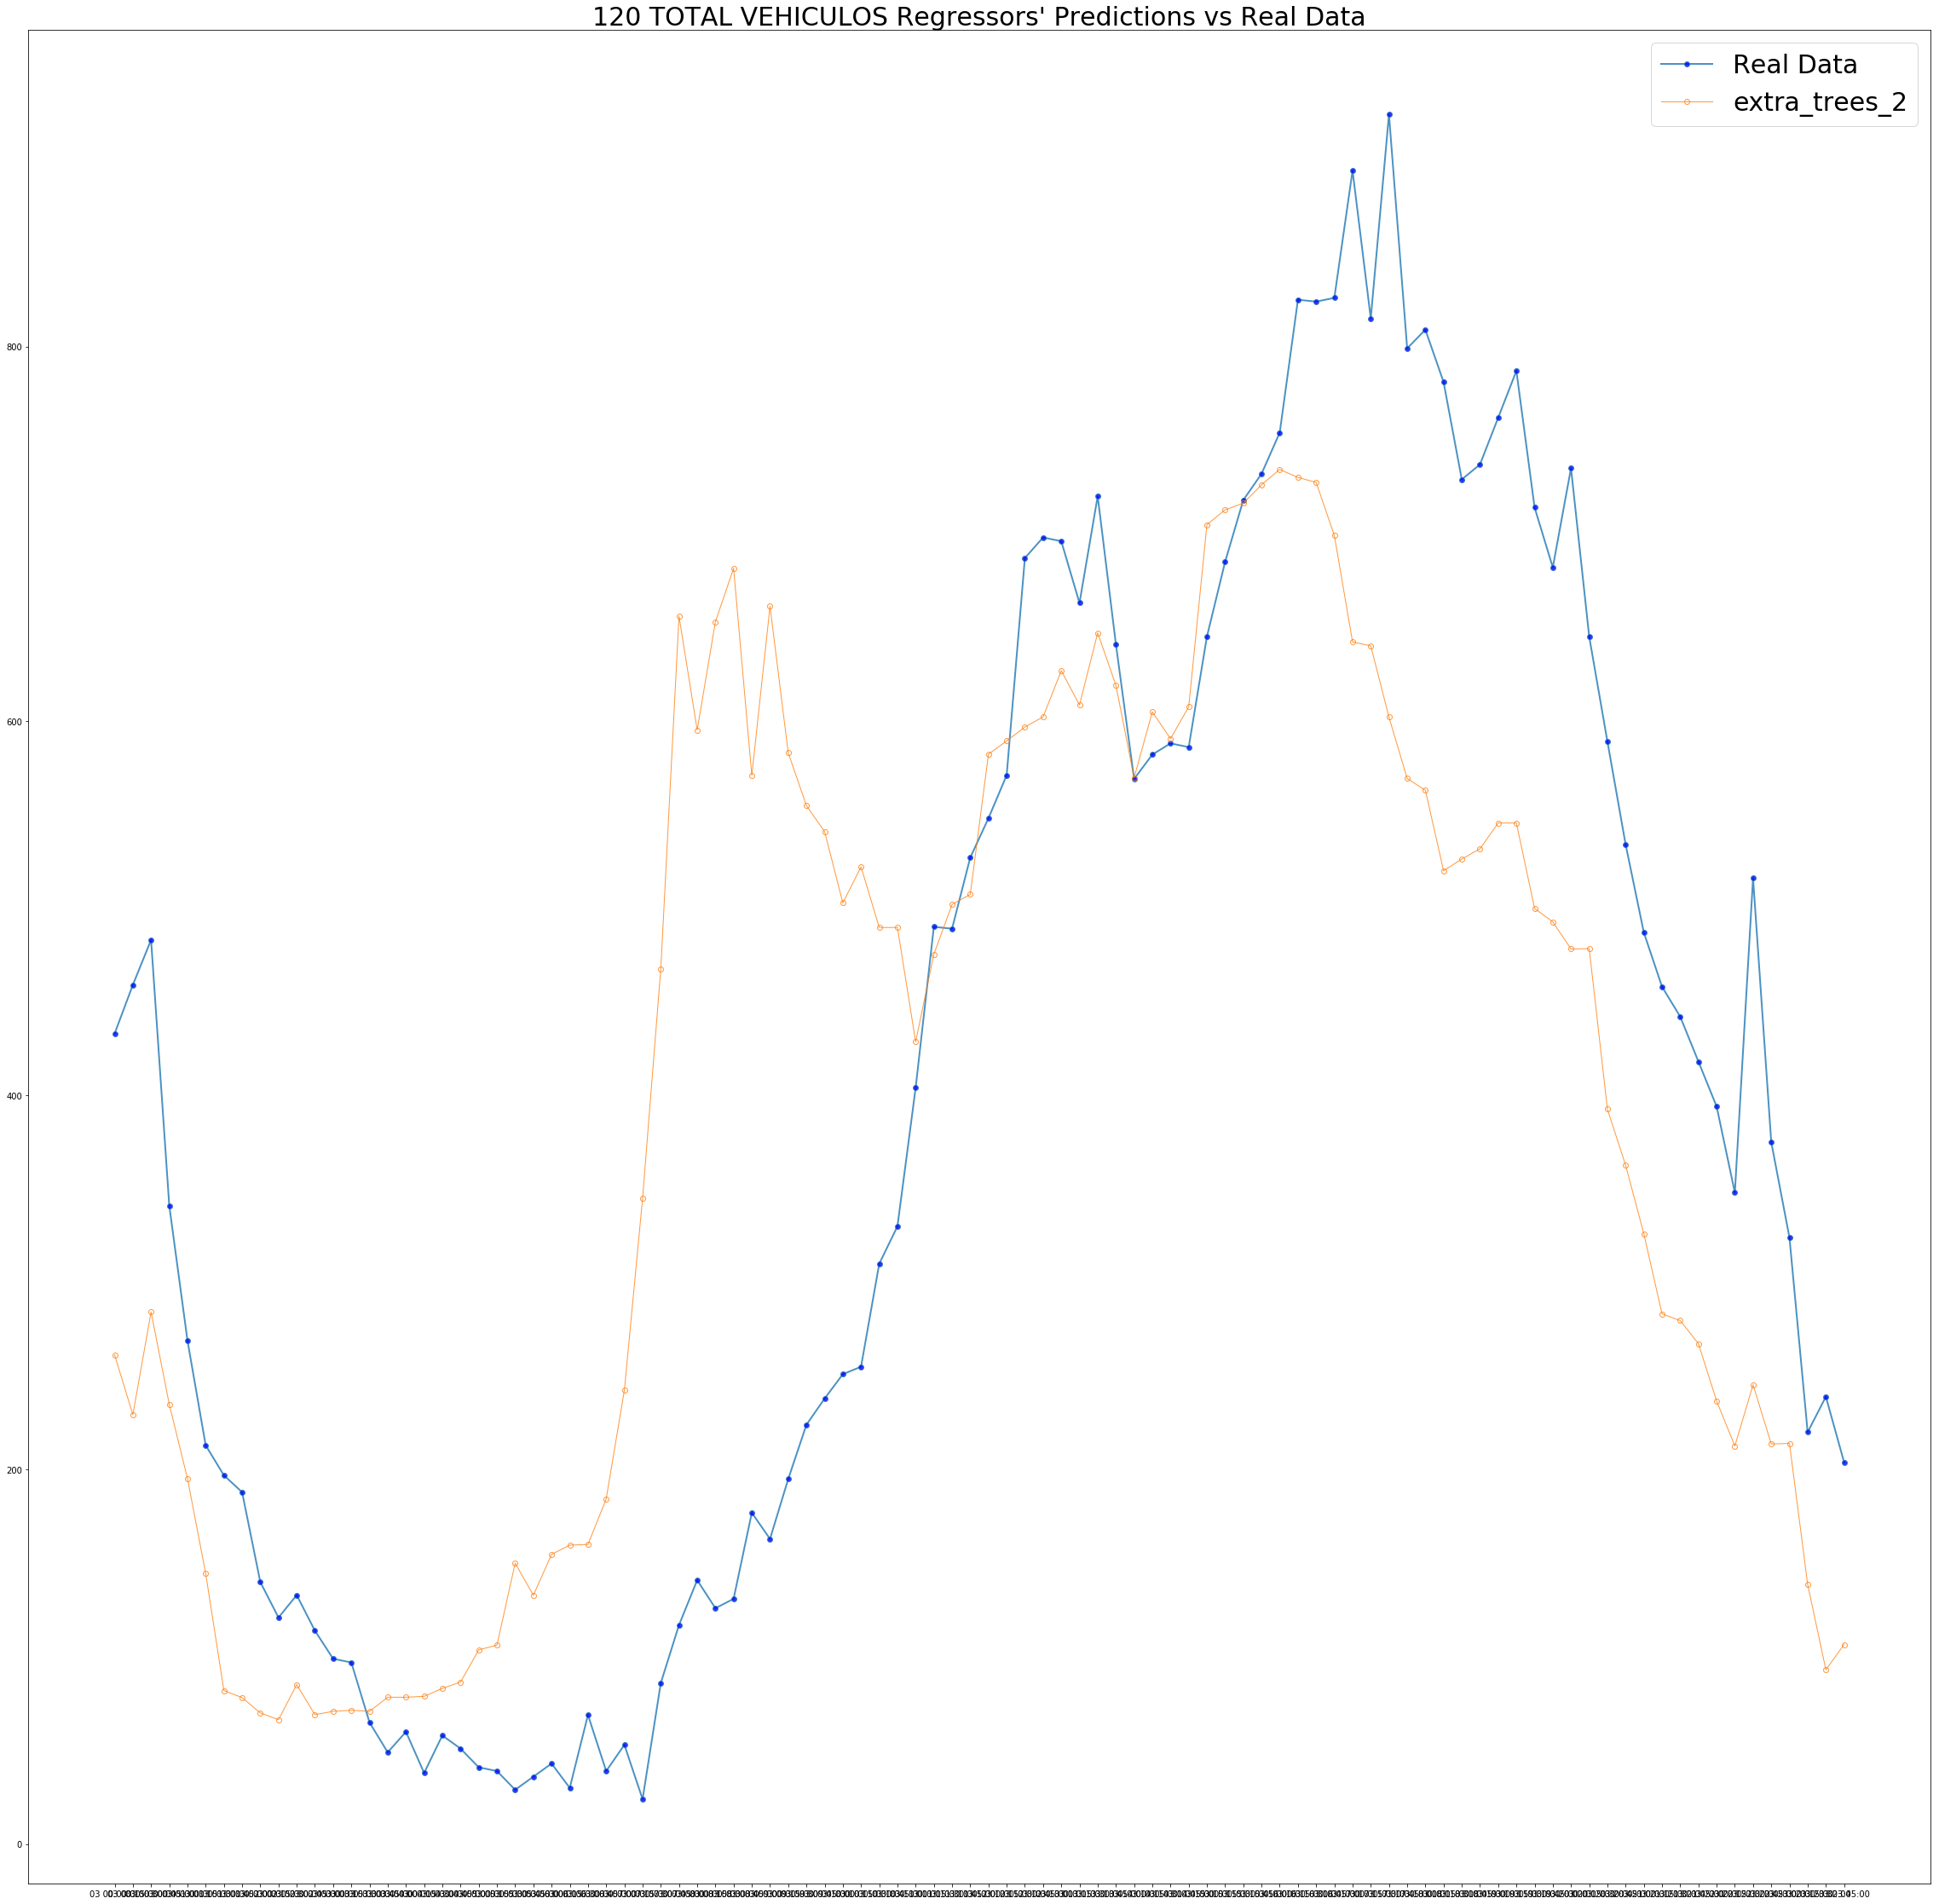

In [435]:
%matplotlib inline

#plt.figure(figsize=(40,40))
#plt.title("TOTAL VEHICULOS Regressors' Predictions vs Real Data" ,  fontsize=30)
#plt.plot(test_data.TIME[0:400], y_test[0:400],'-o', markerfacecolor="blue", label='Real Data', linewidth=2, alpha=0.8)

#plt.plot(train_data.TIME[0:400], y_train[0:400],'-o', markerfacecolor="orange", label='Train Data', linewidth=2, alpha=0.5)


#y_test_pred = model.predict(test_data)
'''
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='MLPRegressor', linewidth=1, alpha=0.8)
y_test_pred = ExtraTreesRegressor_2.predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='ExtraTreesRegressor', linewidth=1, alpha=0.8)
y_test_pred = MLPRegressor.predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='MLPRegressor', linewidth=1, alpha=0.8)
y_test_pred = RandomForestRegressor.predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='ExtraTreesRegressor', linewidth=1, alpha=0.8)
'''
#for horizon, values in forecast_horizon:   
plt.figure(figsize=(40,40))
plt.title("120 TOTAL VEHICULOS Regressors' Predictions vs Real Data" ,  fontsize=30)
y_test = test_data_2['2019-02-03 00:00:00':'2019-02-04 00:00:00']['TOTAL_VEHICULOS']

plt.plot(test_data_2['2019-02-03 00:00:00':'2019-02-04 00:00:00']['TIME'], y_test,'-o', markerfacecolor="blue", label='Real Data', linewidth=2, alpha=0.8)

y_test_pred = mlmodels_dict[regr_name][model_id].predict(test_data_2['2019-02-03 00:00:00':'2019-02-04 00:00:00'][cols])
plt.plot(test_data_2['2019-02-03 00:00:00':'2019-02-04 00:00:00']['TIME'], y_test_pred,'-o',  markerfacecolor="None" , label=regr_name, linewidth=1, alpha=0.8)
plt.legend(loc='best',  fontsize=30)
plt.show()

### Comparativa ExtraTree Regressor & MLP Neural Network

ValueError: x and y must have same first dimension, but have shapes (400,) and (96,)

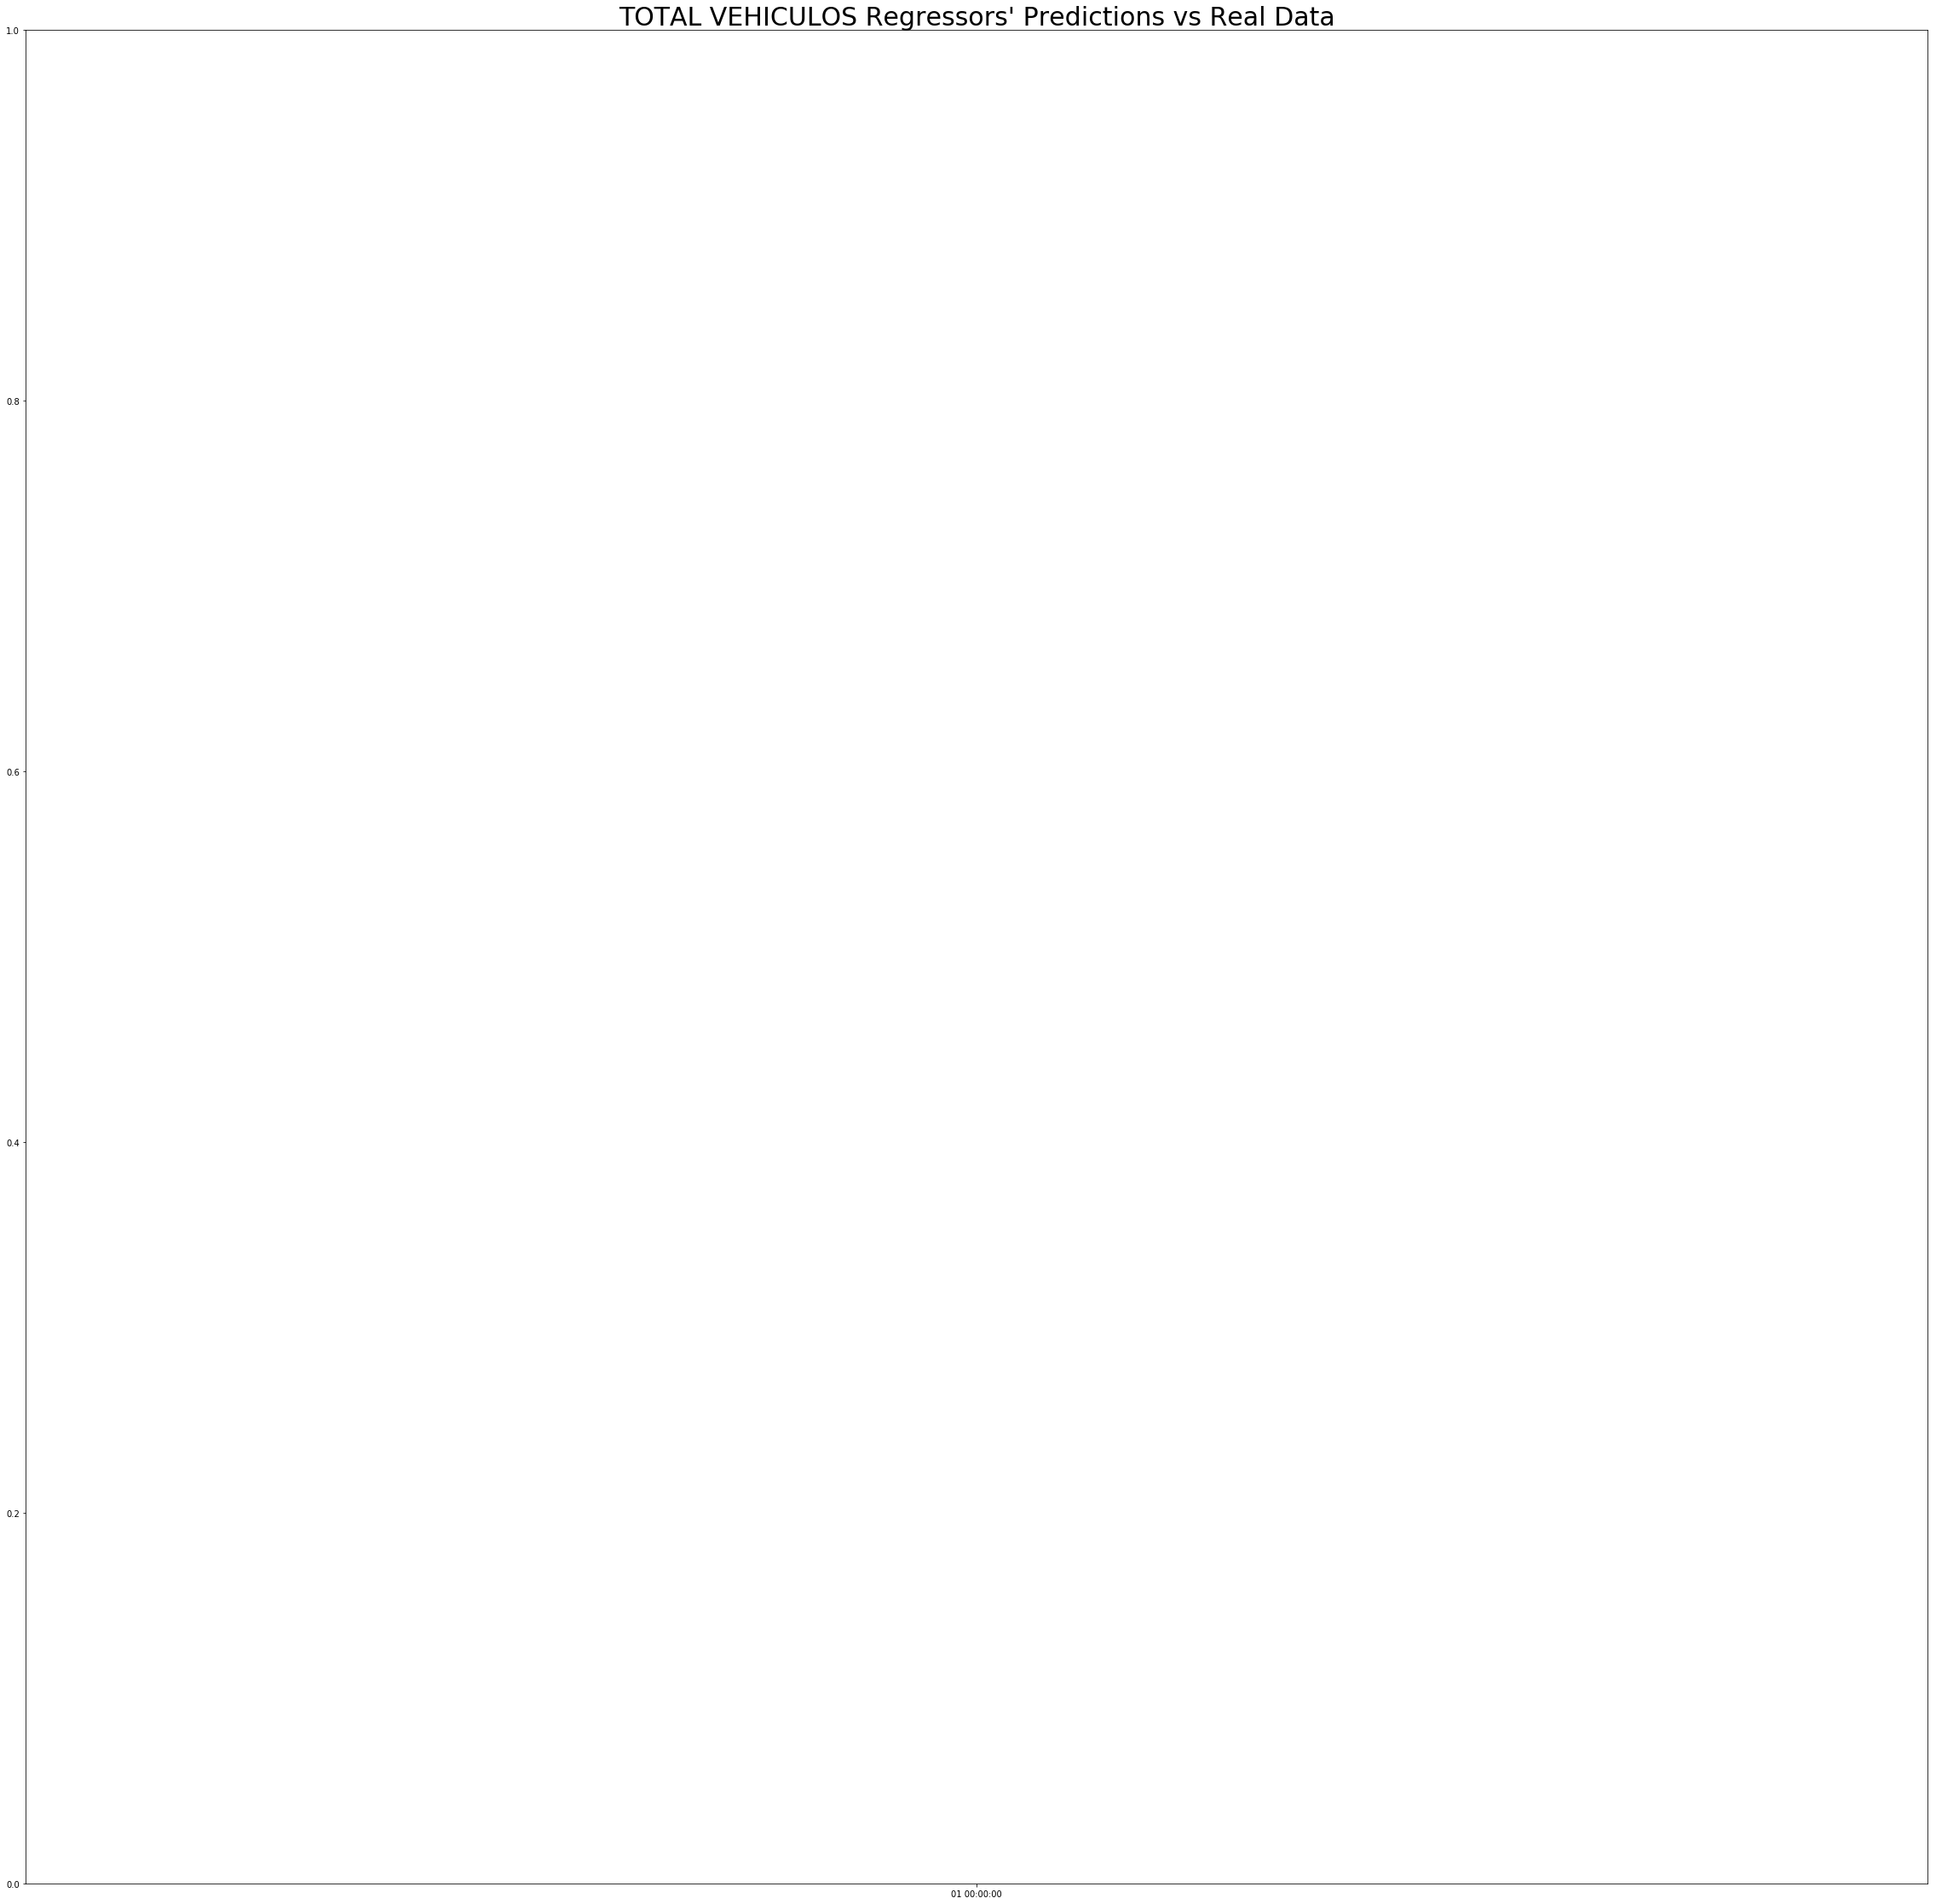

In [141]:
%matplotlib inline

plt.figure(figsize=(40,40))
plt.title("TOTAL VEHICULOS Regressors' Predictions vs Real Data" ,  fontsize=30)

plt.plot(test_data.TIME[0:400], y_test[0:400],'-o', markerfacecolor="blue", label='Real Data', linewidth=2, alpha=0.8)
#plt.plot(train_data.TIME[0:400], y_train[0:400],'-o', markerfacecolor="orange", label='Train Data', linewidth=2, alpha=0.5)

y_test_pred = mlmodels_dict[str('RandomForestRegressor')]['model'].predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='RandomForestRegressor', linewidth=1, alpha=0.8)

y_test_pred = mlmodels_dict[str('ExtraTreesRegressor_2')]['model'].predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='ExtraTreesRegressor_2', linewidth=1, alpha=0.8)
    
y_test_pred = mlmodels_dict[str('MLPRegressor')]['model'].predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='MLPRegressor', linewidth=1, alpha=0.8)

plt.legend(loc='best',  fontsize=30)
plt.show()

### Comparativa Real y Train

In [136]:
train_data = train_data.loc[train_data['MES']==2] # cogemos el mes 2

In [140]:
%matplotlib inline

plt.figure(figsize=(40,40))
plt.title("TOTAL VEHICULOS Regressors' Predictions vs Real Data MES FEBRERO" ,  fontsize=30)

plt.plot(test_data.TIME[0:400], y_test[0:400],'-o', markerfacecolor="blue", label='Real Data', linewidth=2, alpha=0.8)
plt.plot(train_data.TIME[0:400], y_train[0:400],'-o', markerfacecolor="orange", label='Last Year Data', linewidth=2, alpha=0.5)
    
y_test_pred = mlmodels_dict[str('MLPRegressor')]['model'].predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='MLPRegressor', linewidth=1, alpha=1)

plt.legend(loc='best',  fontsize=30)
plt.show()

In [ ]:
%matplotlib inline

plt.figure(figsize=(40,40))
plt.title("TOTAL VEHICULOS Regressors' Predictions vs Real Data MES FEBRERO" ,  fontsize=30)

plt.plot(test_data.TIME[0:400], y_test[0:400],'-o', markerfacecolor="blue", label='Real Data', linewidth=2, alpha=0.8)
plt.plot(train_data.TIME[0:400], y_train[0:400],'-o', markerfacecolor="orange", label='Last Year Data', linewidth=2, alpha=0.5)
    
y_test_pred = mlmodels_dict[str('MLPRegressor')]['model'].predict(x_test)
plt.plot(test_data.TIME[0:400], y_test_pred[0:400],'-o',  markerfacecolor="None" , label='MLPRegressor', linewidth=1, alpha=1)

plt.legend(loc='best',  fontsize=30)
plt.show()

In [118]:
train_data.head()

In [119]:
test_data.head()